# Introduction to image segmentation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Dataset Generation
The code implements a synthetic dataset generator that creates circle images with noise.
1. **Input Generation**:
   - Creates random circles with varying positions and sizes
   - Adds Gaussian noise to create noisy input images
2. **Target Generation**:
   - Clean circle images without noise
   - Created using distance-based calculation

In [ ]:
# Create a simple dataset
class SimpleDataset(Dataset):
    def __init__(self, size=100, image_size=128):
        self.size = size
        self.image_size = image_size

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        # Create a random input image
        center_x = np.random.randint(0, self.image_size)
        center_y = np.random.randint(0, self.image_size)
        radius = np.random.randint(10, self.image_size // 4)

        x, y = torch.meshgrid(torch.arange(self.image_size), torch.arange(self.image_size))
        distance = ((x - center_x)**2 + (y - center_y)**2).sqrt()
        target = (distance < radius).float().unsqueeze(0)

        # Add noise to the target to create the input image
        noise = torch.randn(1, self.image_size, self.image_size) * 0.8
        input_image = target + noise

        return input_image, target

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


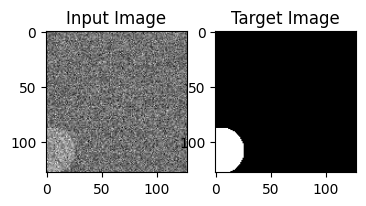

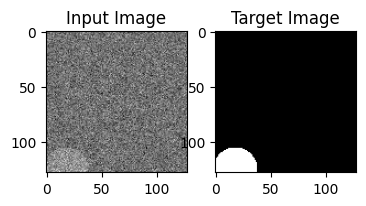

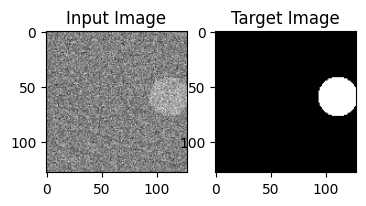

In [ ]:
import matplotlib.pyplot as plt
# Create an instance of the dataset
dataset = SimpleDataset(size=1, image_size=128)

# Get a sample from the dataset
for i in range(3):
    input_image, target = dataset[i]
    # Visualize the input image
    plt.figure(figsize=(4, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(input_image[0], cmap='gray')
    plt.title('Input Image')
    # plt.show()
    # Visualize the target image
    plt.subplot(1, 2, 2)
    plt.imshow(target[0], cmap='gray')
    plt.title('Target Image')
    plt.show()
    # break


# Model Architectures: Simple image to image

[Simple Autoencoder](https://blog.paperspace.com/convolutional-autoencoder/)

Features:
- Single downsample layer (Conv2d)
- Single upsample layer (ConvTranspose2d)
- Minimal architecture for demonstration

In [ ]:
# Define a simple model with ConvTranspose2d
class SimpleAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv layer to reduce spatial dimensions
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=4, stride=2, padding=1)
        # ConvTranspose2d layer to increase spatial dimensions
        self.conv_transpose = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        # Downsample
        x = self.conv(x)
        # Upsample
        x = self.conv_transpose(x)
        x=torch.sigmoid(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = SimpleDataset()
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
# Training loop
def training_loop(model, train_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, (data, targets) in enumerate(train_loader):
            data = data.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        avg_loss = train_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

In [ ]:
# Initialize the model, loss function, and optimizer
model = SimpleAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
training_loop(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/100], Average Loss: 0.2925
Epoch [2/100], Average Loss: 0.2893
Epoch [3/100], Average Loss: 0.2865
Epoch [4/100], Average Loss: 0.2839
Epoch [5/100], Average Loss: 0.2800
Epoch [6/100], Average Loss: 0.2766
Epoch [7/100], Average Loss: 0.2727
Epoch [8/100], Average Loss: 0.2684
Epoch [9/100], Average Loss: 0.2640
Epoch [10/100], Average Loss: 0.2591
Epoch [11/100], Average Loss: 0.2541
Epoch [12/100], Average Loss: 0.2484
Epoch [13/100], Average Loss: 0.2430
Epoch [14/100], Average Loss: 0.2368
Epoch [15/100], Average Loss: 0.2311
Epoch [16/100], Average Loss: 0.2250
Epoch [17/100], Average Loss: 0.2187
Epoch [18/100], Average Loss: 0.2127
Epoch [19/100], Average Loss: 0.2067
Epoch [20/100], Average Loss: 0.2001
Epoch [21/100], Average Loss: 0.1945
Epoch [22/100], Average Loss: 0.1885
Epoch [23/100], Average Loss: 0.1832
Epoch [24/100], Average Loss: 0.1781
Epoch [25/100], Average Loss: 0.1718
Epoch [26/100], Average Loss: 0.1671
Epoch [27/100], Average Loss: 0.1608
Epoch [28/

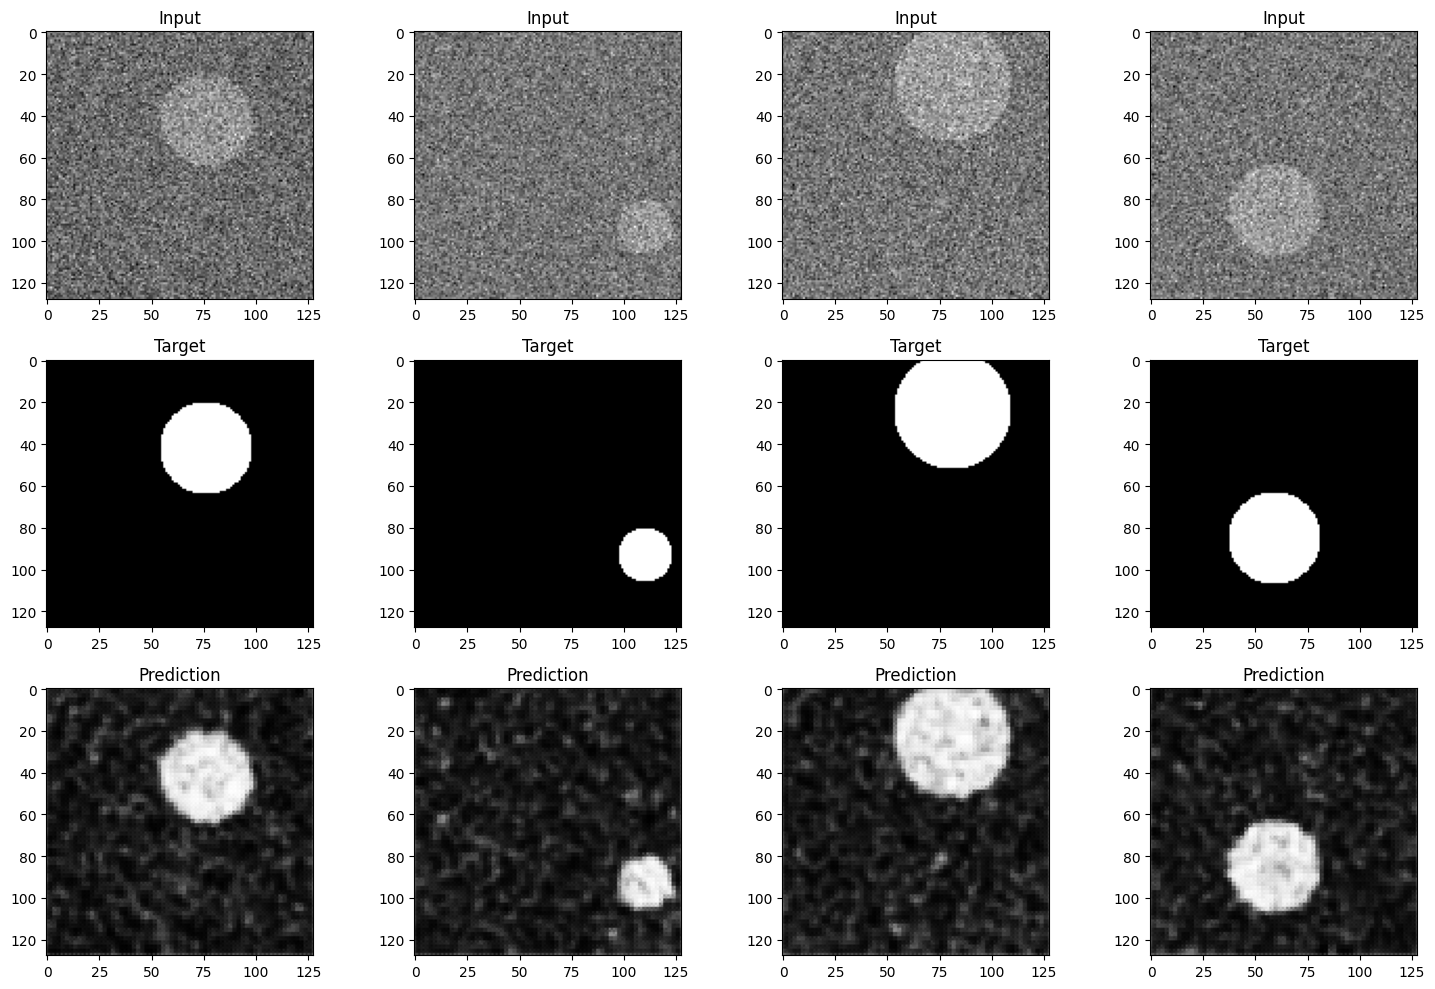

In [ ]:
# Visualize results
model.eval()
with torch.no_grad():
    inputs, targets = next(iter(train_loader))
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)

    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    for i in range(4):
        axes[0, i].imshow(inputs[i, 0].cpu(), cmap='gray')
        axes[0, i].set_title('Input')
        axes[1, i].imshow(targets[i, 0].cpu(), cmap='gray')
        axes[1, i].set_title('Target')
        axes[2, i].imshow(outputs[i, 0].cpu(), cmap='gray')
        axes[2, i].set_title('Prediction')

    plt.tight_layout()
    plt.show()

### Advanced Autoencoder
Architecture Details:
1. **Encoder**:
   - Progressive feature extraction
   - Increasing channel depth (1→16→32→64)
   - Decreasing spatial dimensions
   - ReLU activation for non-linearity

2. **Decoder**:
   - Mirror structure of encoder
   - Decreasing channel depth (64→32→16→1)
   - Increasing spatial dimensions
   - Sigmoid activation for final output

3. **Key Components**:
   - `output_padding=1`: Handles odd dimensions in upsampling
   - Symmetric channel progression
   - Skip connections not implemented (could be added for better results)


![picture](https://miro.medium.com/v2/resize:fit:640/format:webp/1*nqzWupxC60iAH2dYrFT78Q.png)

credit image: https://medium.com/@birla.deepak26/autoencoders-76bb49ae6a8f

In [ ]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
training_loop(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/100], Average Loss: 0.2745
Epoch [2/100], Average Loss: 0.1819
Epoch [3/100], Average Loss: 0.0971
Epoch [4/100], Average Loss: 0.0821
Epoch [5/100], Average Loss: 0.0685
Epoch [6/100], Average Loss: 0.0595
Epoch [7/100], Average Loss: 0.0724
Epoch [8/100], Average Loss: 0.0765
Epoch [9/100], Average Loss: 0.0685
Epoch [10/100], Average Loss: 0.0513
Epoch [11/100], Average Loss: 0.0344
Epoch [12/100], Average Loss: 0.0278
Epoch [13/100], Average Loss: 0.0208
Epoch [14/100], Average Loss: 0.0168
Epoch [15/100], Average Loss: 0.0145
Epoch [16/100], Average Loss: 0.0137
Epoch [17/100], Average Loss: 0.0129
Epoch [18/100], Average Loss: 0.0117
Epoch [19/100], Average Loss: 0.0098
Epoch [20/100], Average Loss: 0.0098
Epoch [21/100], Average Loss: 0.0083
Epoch [22/100], Average Loss: 0.0063
Epoch [23/100], Average Loss: 0.0064
Epoch [24/100], Average Loss: 0.0059
Epoch [25/100], Average Loss: 0.0057
Epoch [26/100], Average Loss: 0.0055
Epoch [27/100], Average Loss: 0.0047
Epoch [28/

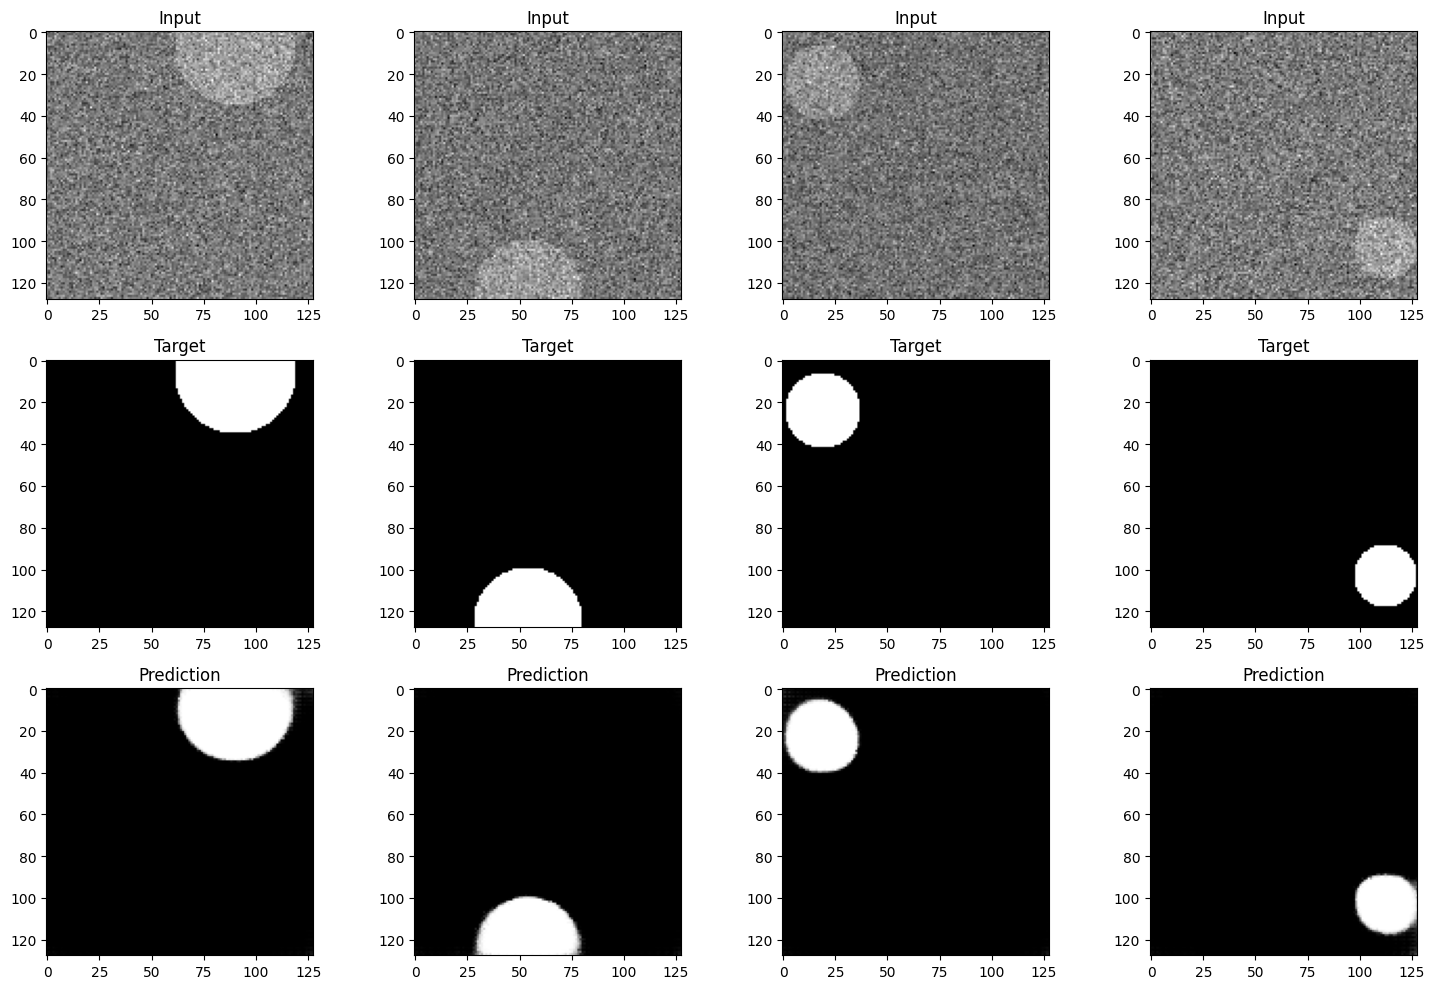

In [ ]:
# Visualize results
model.eval()
with torch.no_grad():
    inputs, targets = next(iter(train_loader))
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)

    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    for i in range(4):
        axes[0, i].imshow(inputs[i, 0].cpu(), cmap='gray')
        axes[0, i].set_title('Input')
        axes[1, i].imshow(targets[i, 0].cpu(), cmap='gray')
        axes[1, i].set_title('Target')
        axes[2, i].imshow(outputs[i, 0].cpu(), cmap='gray')
        axes[2, i].set_title('Prediction')

    plt.tight_layout()
    plt.show()

## Common Issues and Solutions

1. **Checkerboard Artifacts**:
   - Caused by transposed convolutions
   - Solution: Use resize-convolution instead

2. **Blurry Outputs**:
   - Common with MSE loss
   - Solution: Add perceptual or adversarial loss

3. **Training Stability**:
   - Monitor loss curves
   - Adjust learning rate if needed
   - Add gradient clipping if necessary

# U-Net architecture
[Pytorch-UNet](https://github.com/milesial/Pytorch-UNet)

U-Net is a convolutional neural network architecture designed for biomedical image segmentation. Its name comes from its U-shaped architecture, consisting of:
- Contracting path (encoder)
- Expanding path (decoder)
- Skip connections between corresponding encoder and decoder layers
### Data Flow:

1. **Encoder Path**:
   - Input → e1: 1→64 channels
   - e1 → e2: 64→128 channels
   - e2 → e3: 128→256 channels
   - e3 → e4: 256→512 channels

2. **Skip Connections**:
   - d1 + e3: 256 + 256 = 512 channels
   - d2 + e2: 128 + 128 = 256 channels
   - d3 + e1: 64 + 64 = 128 channels

3. **Decoder Path**:
   - e4 → d1: 512→256 channels
   - [d1,e3] → d2: 512→128 channels
   - [d2,e2] → d3: 256→64 channels
   - [d3,e1] → out: 128→1 channels

![picture](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png)

credit image: https://arxiv.org/abs/1505.04597v1

In [ ]:
# Define the U-Net architecture
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder (downsampling)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Decoder (upsampling)
        self.dec1 = self.upconv_block(512, 256)
        self.dec2 = self.upconv_block(512, 128)
        self.dec3 = self.upconv_block(256, 64)
        self.final = nn.Conv2d(128, out_channels, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(nn.functional.max_pool2d(e1, 2))
        e3 = self.enc3(nn.functional.max_pool2d(e2, 2))
        e4 = self.enc4(nn.functional.max_pool2d(e3, 2))

        # Decoder
        d1 = self.dec1(e4)
        d2 = self.dec2(torch.cat([d1, e3], dim=1))
        d3 = self.dec3(torch.cat([d2, e2], dim=1))
        out = self.final(torch.cat([d3, e1], dim=1))

        return out

In [ ]:
model = UNet(in_channels=1, out_channels=1).to(device)
# criterion = nn.MSELoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
training_loop(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/100], Average Loss: 0.9482
Epoch [2/100], Average Loss: 0.4623
Epoch [3/100], Average Loss: 0.3606
Epoch [4/100], Average Loss: 0.1984
Epoch [5/100], Average Loss: 0.1001
Epoch [6/100], Average Loss: 0.0615
Epoch [7/100], Average Loss: 0.0250
Epoch [8/100], Average Loss: 0.0087
Epoch [9/100], Average Loss: 0.0081
Epoch [10/100], Average Loss: 0.0071
Epoch [11/100], Average Loss: 0.0073
Epoch [12/100], Average Loss: 0.0077
Epoch [13/100], Average Loss: 0.0070
Epoch [14/100], Average Loss: 0.0070
Epoch [15/100], Average Loss: 0.0073
Epoch [16/100], Average Loss: 0.0066
Epoch [17/100], Average Loss: 0.0072
Epoch [18/100], Average Loss: 0.0067
Epoch [19/100], Average Loss: 0.0066
Epoch [20/100], Average Loss: 0.0072
Epoch [21/100], Average Loss: 0.0063
Epoch [22/100], Average Loss: 0.0066
Epoch [23/100], Average Loss: 0.0062
Epoch [24/100], Average Loss: 0.0068
Epoch [25/100], Average Loss: 0.0065
Epoch [26/100], Average Loss: 0.0065
Epoch [27/100], Average Loss: 0.0063
Epoch [28/

In [ ]:
# Create the dataset and data loader
dataset = SimpleDataset()
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

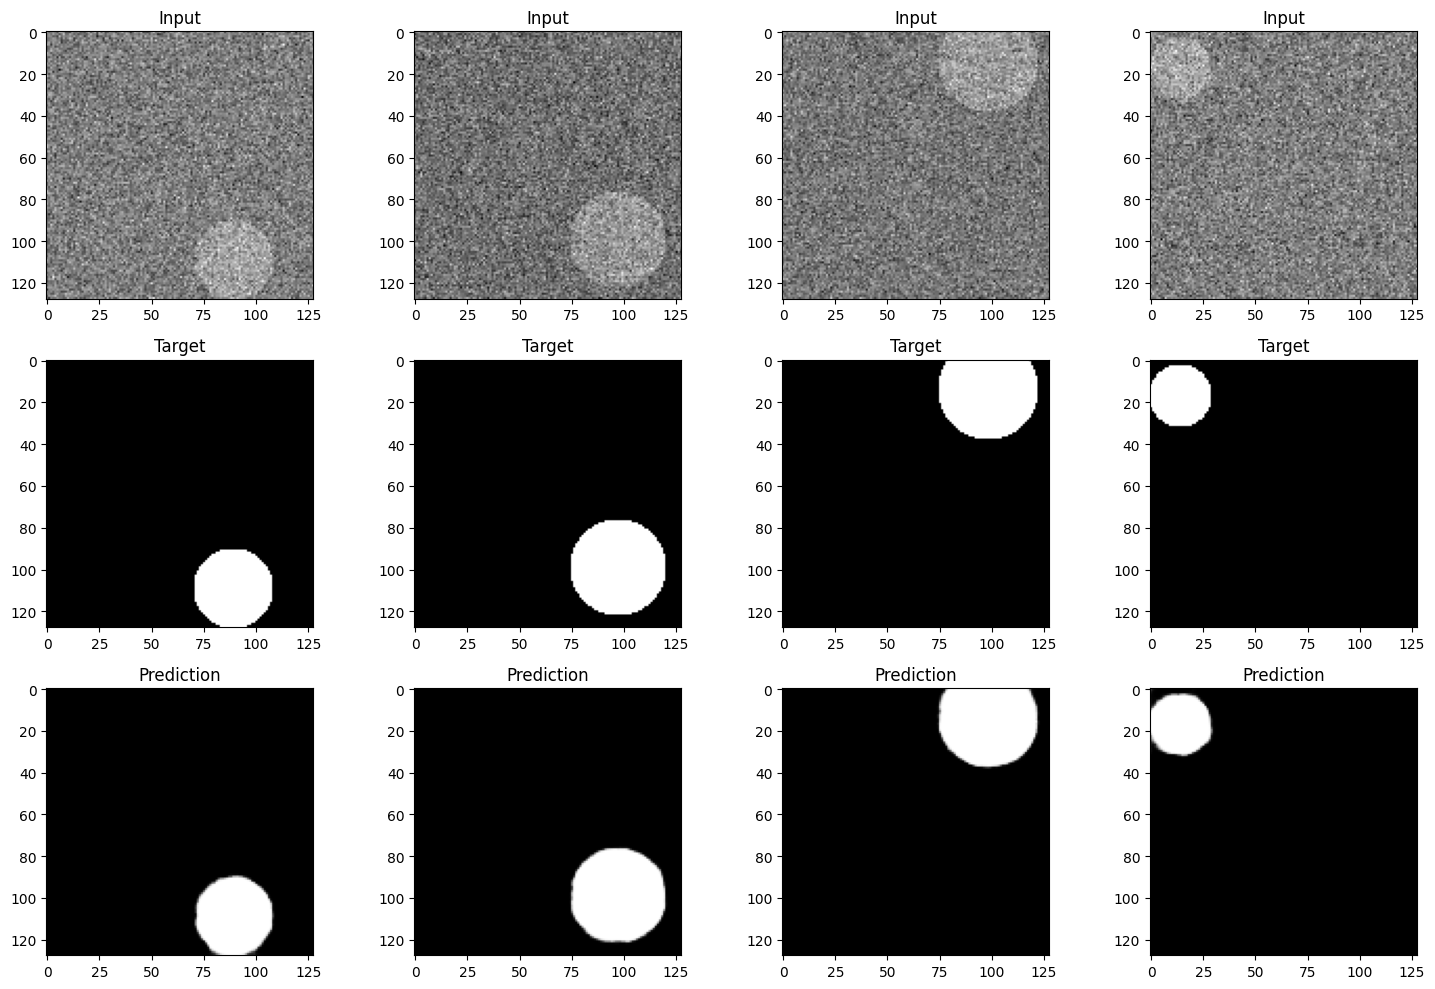

In [ ]:
# Visualize results
model.eval()
with torch.no_grad():
    inputs, targets = next(iter(dataloader))
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)

    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    for i in range(4):
        axes[0, i].imshow(inputs[i, 0].cpu(), cmap='gray')
        axes[0, i].set_title('Input')
        axes[1, i].imshow(targets[i, 0].cpu(), cmap='gray')
        axes[1, i].set_title('Target')
        axes[2, i].imshow(outputs[i, 0].cpu(), cmap='gray')
        axes[2, i].set_title('Prediction')

    plt.tight_layout()
    plt.show()

In [ ]:
# !pip install torchviz

In [ ]:
# # Visualize the model architecture
# from torchviz import make_dot

# x = torch.randn(1, 1, 128, 128).to(device)
# y = model(x)
# dot = make_dot(y.mean(), params=dict(model.named_parameters()))
# dot.render("unet_architecture", format="png")

# Multiple object
- Channel 0: Circle mask
- Channel 1: Rectangle mask

In [ ]:
class SimpleDataset(Dataset):
    def __init__(self, size=100, image_size=128):
        self.size = size
        self.image_size = image_size

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        # Create a blank canvas for target
        target = torch.zeros(2, self.image_size, self.image_size)

        # Generate circle
        center_x = np.random.randint(0, self.image_size)
        center_y = np.random.randint(0, self.image_size)
        radius = np.random.randint(10, self.image_size // 6)
        x, y = torch.meshgrid(torch.arange(self.image_size), torch.arange(self.image_size))
        distance = ((x - center_x)**2 + (y - center_y)**2).sqrt()
        target[0] = (distance < radius).float()

        # Generate rectangle
        rect_x = np.random.randint(0, self.image_size - self.image_size // 4)
        rect_y = np.random.randint(0, self.image_size - self.image_size // 4)
        rect_w = np.random.randint(self.image_size // 8, self.image_size // 4)
        rect_h = np.random.randint(self.image_size // 8, self.image_size // 4)
        target[1, rect_x:rect_x+rect_w, rect_y:rect_y+rect_h] = 1

        # Combine circle and rectangle
        combined_target = (target.sum(dim=0) > 0).float().unsqueeze(0)

        # Add noise to create the input image
        noise = torch.randn(1, self.image_size, self.image_size) * 0.5
        input_image = combined_target + noise

        return input_image, target

# U-Net Architecture for Multiple Objects
## Implementation Details
1. **Input Processing**:
   - Single channel noisy image
   - Size: 128x128x1

2. **Feature Extraction**:
   - Progressive downsampling
   - Increasing feature channels

3. **Decoding Process**:
   - Progressive upsampling
   - Skip connections
   - Final output: 2 channel masks

4. **Output Processing**:
   - Channel 0: Circle probability map
   - Channel 1: Rectangle probability map

In [ ]:
# Define the U-Net architecture (unchanged)
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder (downsampling)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Decoder (upsampling)
        self.dec1 = self.upconv_block(512, 256)
        self.dec2 = self.upconv_block(512, 128)
        self.dec3 = self.upconv_block(256, 64)
        self.final = nn.Conv2d(128, out_channels, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(nn.functional.max_pool2d(e1, 2))
        e3 = self.enc3(nn.functional.max_pool2d(e2, 2))
        e4 = self.enc4(nn.functional.max_pool2d(e3, 2))

        # Decoder
        d1 = self.dec1(e4)
        d2 = self.dec2(torch.cat([d1, e3], dim=1))
        d3 = self.dec3(torch.cat([d2, e2], dim=1))
        out = self.final(torch.cat([d3, e1], dim=1))

        return out

In [ ]:
# Create the dataset and data loader
dataset = SimpleDataset()
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
model = UNet(in_channels=1, out_channels=2).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
num_epochs = 5
training_loop(model, train_loader, criterion, optimizer, num_epochs)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch [1/5], Average Loss: 0.5115
Epoch [2/5], Average Loss: 0.1862
Epoch [3/5], Average Loss: 0.1042
Epoch [4/5], Average Loss: 0.0750
Epoch [5/5], Average Loss: 0.0645


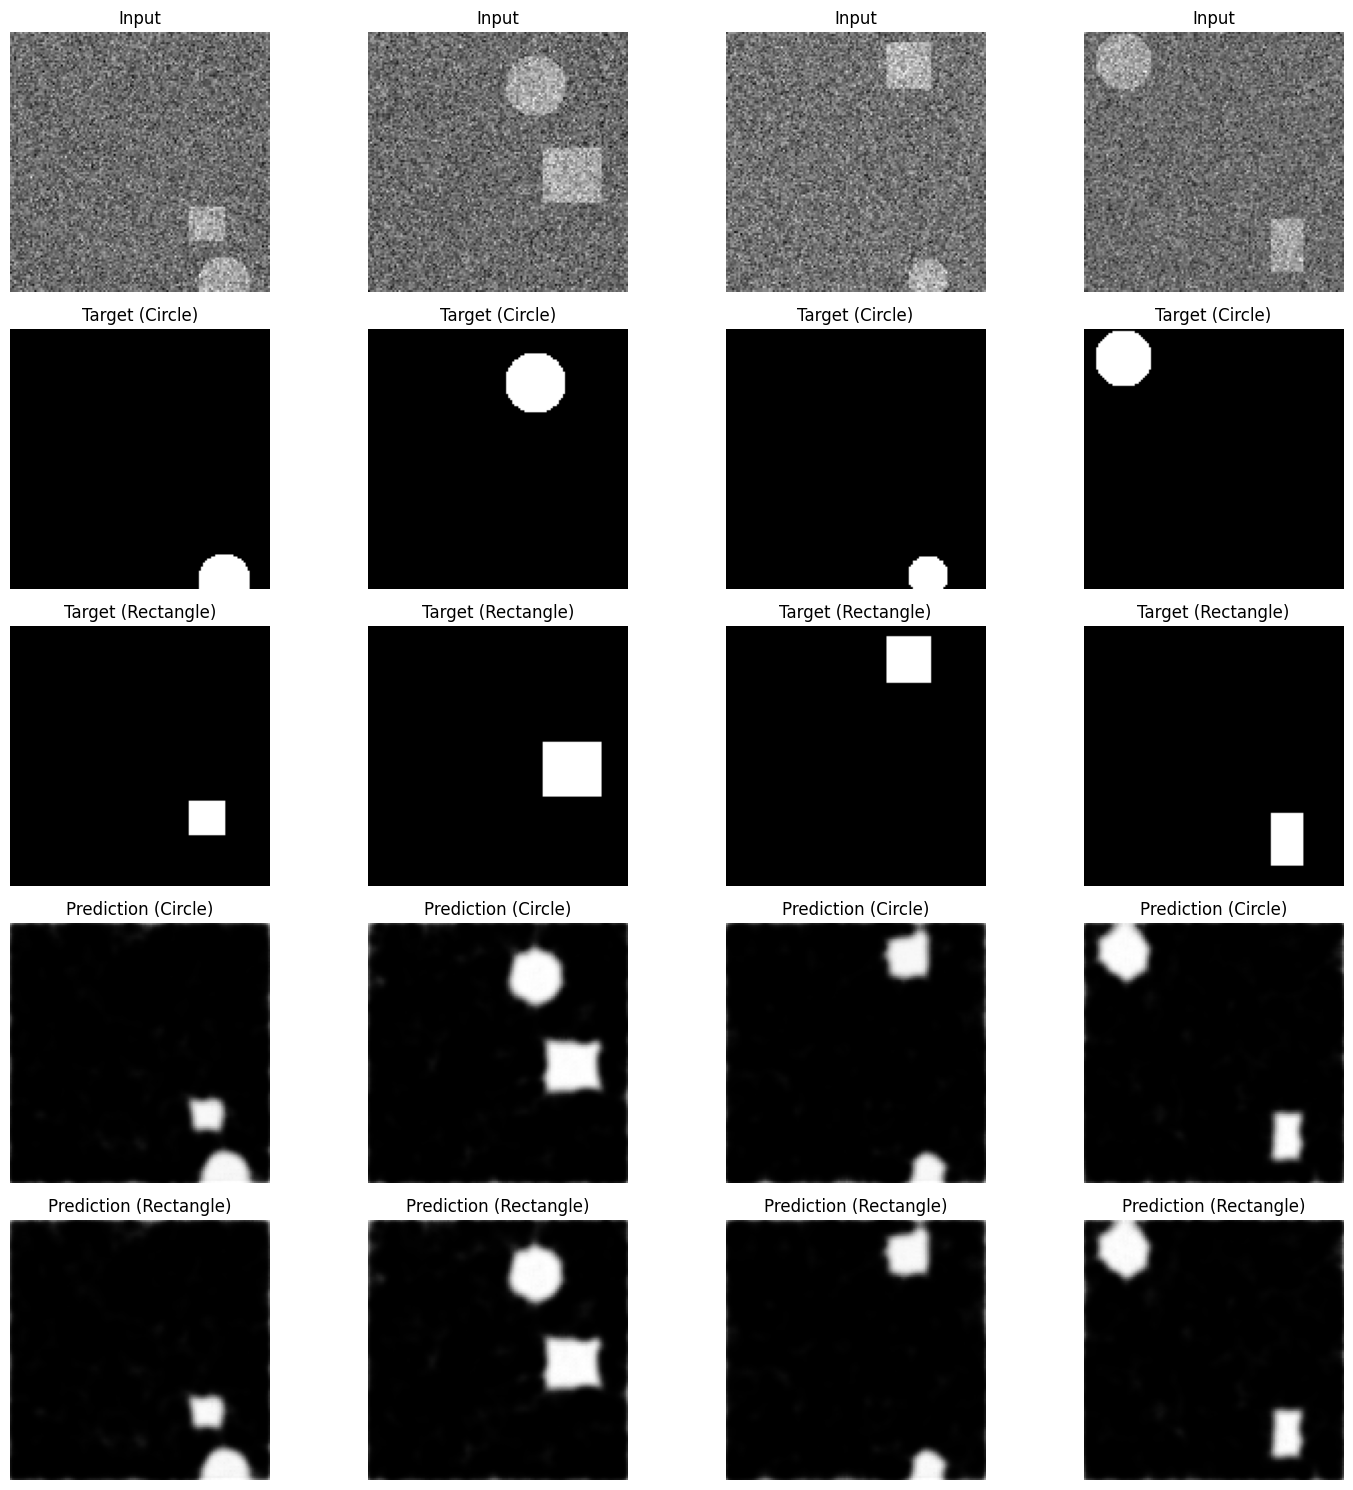

In [ ]:
# Visualize results
# Create the dataset and data loader
dataset = SimpleDataset()
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

model.eval()
with torch.no_grad():
    inputs, targets = next(iter(dataloader))
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)

    fig, axes = plt.subplots(5, 4, figsize=(15, 15))
    for i in range(4):
        axes[0, i].imshow(inputs[i, 0].cpu(), cmap='gray')
        axes[0, i].set_title('Input')
        axes[0, i].axis('off')

        axes[1, i].imshow(targets[i, 0].cpu(), cmap='gray')
        axes[1, i].set_title('Target (Circle)')
        axes[1, i].axis('off')

        axes[2, i].imshow(targets[i, 1].cpu(), cmap='gray')
        axes[2, i].set_title('Target (Rectangle)')
        axes[2, i].axis('off')

        axes[3, i].imshow(outputs[i, 0].cpu(), cmap='gray')
        axes[3, i].set_title('Prediction (Circle)')
        axes[3, i].axis('off')

        axes[4, i].imshow(outputs[i, 1].cpu(), cmap='gray')
        axes[4, i].set_title('Prediction (Rectangle)')
        axes[4, i].axis('off')

    plt.tight_layout()
    plt.show()

# Hand on

Revise the code to be able to segment 4 objects per image using U-Net.

## Import Library

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

## Draw Function

In [ ]:
def draw_circle(image_size):
  center_x = np.random.randint(0, image_size)
  center_y = np.random.randint(0, image_size)
  radius = np.random.randint(10, image_size // 6)
  x, y = torch.meshgrid(torch.arange(image_size), torch.arange(image_size))
  distance = ((x - center_x)**2 + (y - center_y)**2).sqrt()
  return (distance < radius).float()


def draw_rectangle(image_size, tensor):
  rect_x = np.random.randint(0, image_size - image_size // 4)
  rect_y = np.random.randint(0, image_size - image_size // 4)
  rect_w = np.random.randint(image_size // 8, image_size // 4)
  rect_h = np.random.randint(image_size // 8, image_size // 4)
  tensor[rect_x:rect_x+rect_w, rect_y:rect_y+rect_h] = 1
  return tensor

def draw_triangle(image_size):
  tri_h = np.random.randint(image_size//8, image_size//4)
  tri_w = np.random.randint(image_size//8, image_size//4)
  tri_x = np.random.randint(0, image_size - image_size // 4)
  tri_y = np.random.randint(0, image_size - image_size // 4)
  y, x = torch.meshgrid(torch.arange(image_size), torch.arange(image_size), indexing = 'ij')
  slope = (tri_w // 2) / (tri_h - 1)
  center = tri_w + tri_w // 2
  left_boundary = center - slope * (y-tri_y)
  right_boundary = center + slope * (y-tri_y)
  return ((x >= left_boundary) & (x <= right_boundary)).float()

def line_equation(p1, p2):
  slope = (p2[1] - p1[1]) / (p2[0] - p1[0] + 1e-6)
  intercept = p1[1] - slope * p1[0]
  return slope, intercept

def draw_pentagon(image_size):
    pent_h = np.random.randint(image_size // 8, image_size // 4)
    pent_w = np.random.randint(image_size // 8, image_size // 4)
    pent_x = np.random.randint(0, image_size - pent_w)
    pent_y = np.random.randint(0, image_size - pent_h)

    y, x = torch.meshgrid(torch.arange(image_size), torch.arange(image_size), indexing='ij')

    angles = np.linspace(0, 2 * np.pi, 6)
    center_x, center_y = pent_x + pent_w // 2, pent_y + pent_h // 2
    radius_x, radius_y = pent_w // 2, pent_h // 2

    # Calculate the 5 vertices
    vertices = [(center_x + radius_x * np.cos(angle), center_y + radius_y * np.sin(angle)) for angle in angles]

    pentagon_mask = torch.zeros(image_size, image_size)

    for i in range(image_size):
        for j in range(image_size):
            inside = False
            n = len(vertices)
            p1x, p1y = vertices[0]
            for k in range(n + 1):
                p2x, p2y = vertices[k % n]
                if j > min(p1y, p2y):
                    if j <= max(p1y, p2y):
                        if i <= max(p1x, p2x):
                            if p1y != p2y:
                                xinters = (j - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                            if p1x == p2x or i <= xinters:
                                inside = not inside
                p1x, p1y = p2x, p2y

            if inside:
                pentagon_mask[i, j] = 1

    return pentagon_mask

##Create Dataset

In [ ]:
from PIL import Image
import os

# Define the SimpleDataset with 4 objects

class SimpleDataset(Dataset):
    def __init__(self, size=100, image_size=128, save_path=None):
        self.size = size
        self.image_size = image_size
        self.save_path = save_path  # Path for saving input and target data

        # Create directories for saving data
        if save_path:
            os.makedirs(os.path.join(save_path, "input_images"), exist_ok=True)
            os.makedirs(os.path.join(save_path, "targets"), exist_ok=True)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        target = torch.zeros(4, self.image_size, self.image_size)
        # Code here

        # Generate circle
        target[0] = draw_circle(self.image_size) #Generate circle
        target[1] = draw_rectangle(self.image_size, target[1]) #Generate rectangle
        target[2] = draw_triangle(self.image_size) #Generate triangle
        target[3] = draw_pentagon(self.image_size) #Generate pentagon

        combined_target = (target.sum(dim=0) > 0).float().unsqueeze(0)

        noise = torch.randn(1, self.image_size, self.image_size) * 0.5
        input_image = combined_target + noise

        # Save the data if save_path is provided
        if self.save_path:
            self.save_data(input_image, target, idx)

        return input_image, target

    # Opptional for saving image and target
    def save_data(self, input_image, target, idx):
        input_image_path = os.path.join(self.save_path, "input_images", f"input_{idx:04d}.png")
        target_path = os.path.join(self.save_path, "targets", f"target_{idx:04d}.npy")

        # Save input image as .png
        input_image_np = (input_image[0].cpu().numpy() * 255).astype(np.uint8)
        Image.fromarray(input_image_np).save(input_image_path)

        # Save target as .npy
        target_np = target.cpu().numpy()
        np.save(target_path, target_np)

## Visualization Dataset

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


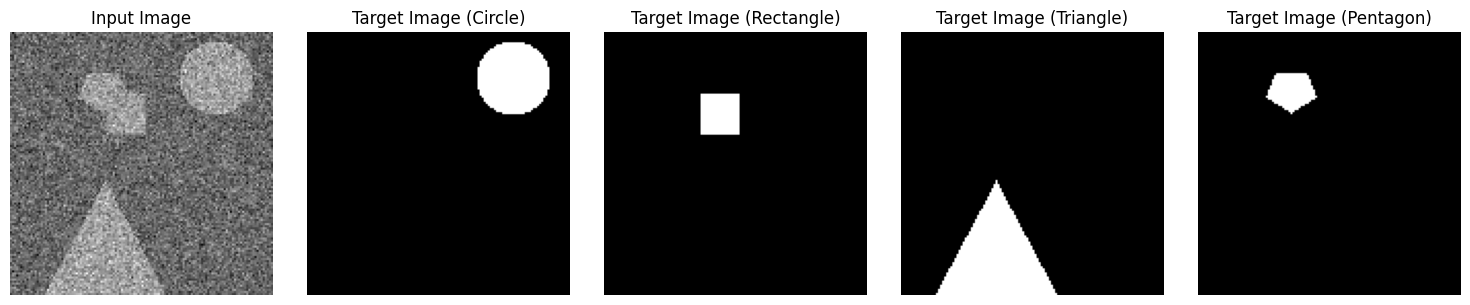

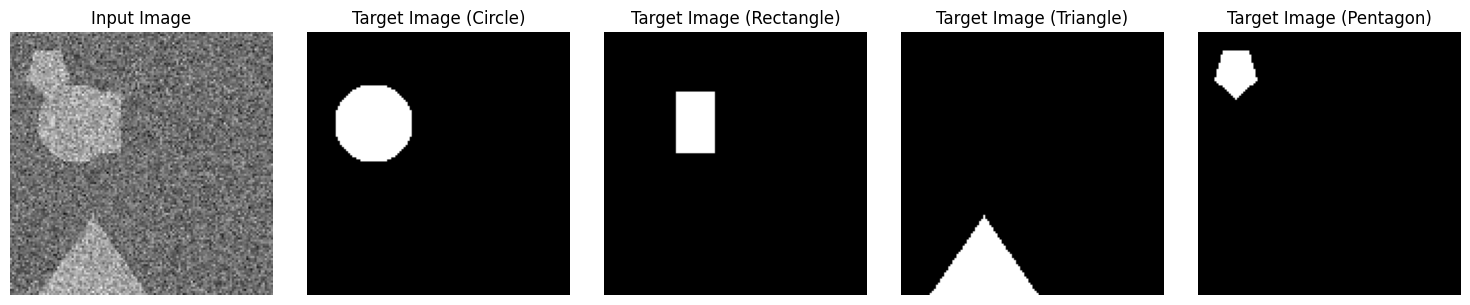

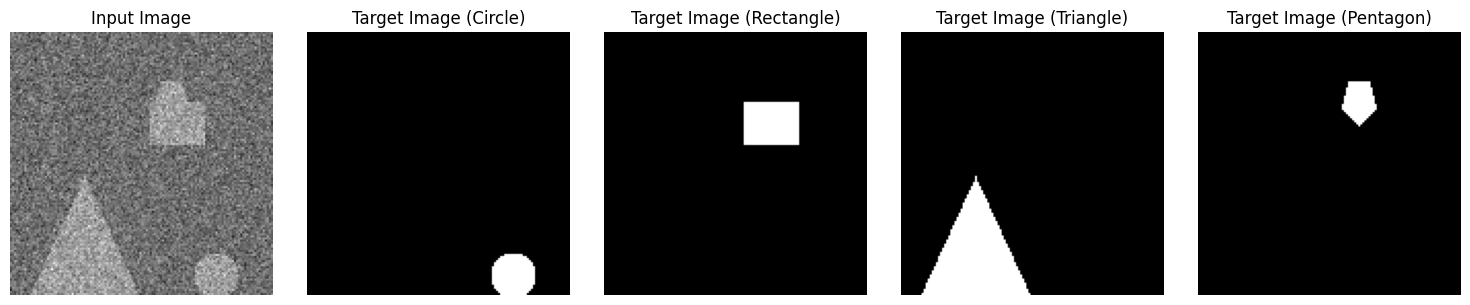

In [ ]:
import matplotlib.pyplot as plt
# Create an instance of the dataset
dataset = SimpleDataset()
# Get a sample from the dataset
for i in range(3):
    input_image, target = dataset[i]
    # Visualize the input image
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 5, 1)
    plt.imshow(input_image[0], cmap='gray')
    plt.title('Input Image')
    plt.axis("off")

    # Visualize the target image
    plt.subplot(1, 5, 2)
    plt.imshow(target[0], cmap='gray')
    plt.title('Target Image (Circle)')
    plt.axis("off")

    plt.subplot(1, 5, 3)
    plt.imshow(target[1], cmap='gray')
    plt.title('Target Image (Rectangle)')
    plt.axis("off")

    plt.subplot(1, 5, 4)
    plt.imshow(target[2], cmap='gray')
    plt.title('Target Image (Triangle)')
    plt.axis("off")

    plt.subplot(1, 5, 5)
    plt.imshow(target[3], cmap='gray')
    plt.title('Target Image (Pentagon)')
    plt.axis("off")

    plt.tight_layout()
    plt.show()

## Model

In [ ]:
# Define the U-Net architecture, code here
# Define the U-Net architecture (unchanged)
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder (downsampling)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Decoder (upsampling)
        self.dec1 = self.upconv_block(512, 256)
        self.dec2 = self.upconv_block(512, 128)
        self.dec3 = self.upconv_block(256, 64)
        self.final = nn.Conv2d(128, out_channels, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(nn.functional.max_pool2d(e1, 2))
        e3 = self.enc3(nn.functional.max_pool2d(e2, 2))
        e4 = self.enc4(nn.functional.max_pool2d(e3, 2))

        # Decoder
        d1 = self.dec1(e4)
        d2 = self.dec2(torch.cat([d1, e3], dim=1))
        d3 = self.dec3(torch.cat([d2, e2], dim=1))
        out = self.final(torch.cat([d3, e1], dim=1))

        return out

In [ ]:
# Training setup, code here
#setup dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = SimpleDataset()
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# setup model
model = UNet(in_channels=1, out_channels=4).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())


In [ ]:
# Training loop, code here
def training_loop(model, train_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, (data, targets) in enumerate(train_loader):
            data = data.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        avg_loss = train_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

# Training loop
num_epochs = 100
training_loop(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/100], Average Loss: 0.1254
Epoch [2/100], Average Loss: 0.1112
Epoch [3/100], Average Loss: 0.0980
Epoch [4/100], Average Loss: 0.0847
Epoch [5/100], Average Loss: 0.0728
Epoch [6/100], Average Loss: 0.0650
Epoch [7/100], Average Loss: 0.0653
Epoch [8/100], Average Loss: 0.0636
Epoch [9/100], Average Loss: 0.0614
Epoch [10/100], Average Loss: 0.0613
Epoch [11/100], Average Loss: 0.0604
Epoch [12/100], Average Loss: 0.0616
Epoch [13/100], Average Loss: 0.0605
Epoch [14/100], Average Loss: 0.0603
Epoch [15/100], Average Loss: 0.0613
Epoch [16/100], Average Loss: 0.0597
Epoch [17/100], Average Loss: 0.0580
Epoch [18/100], Average Loss: 0.0561
Epoch [19/100], Average Loss: 0.0585
Epoch [20/100], Average Loss: 0.0563
Epoch [21/100], Average Loss: 0.0566
Epoch [22/100], Average Loss: 0.0519
Epoch [23/100], Average Loss: 0.0555
Epoch [24/100], Average Loss: 0.0471
Epoch [25/100], Average Loss: 0.0465
Epoch [26/100], Average Loss: 0.0516
Epoch [27/100], Average Loss: 0.0505
Epoch [28/

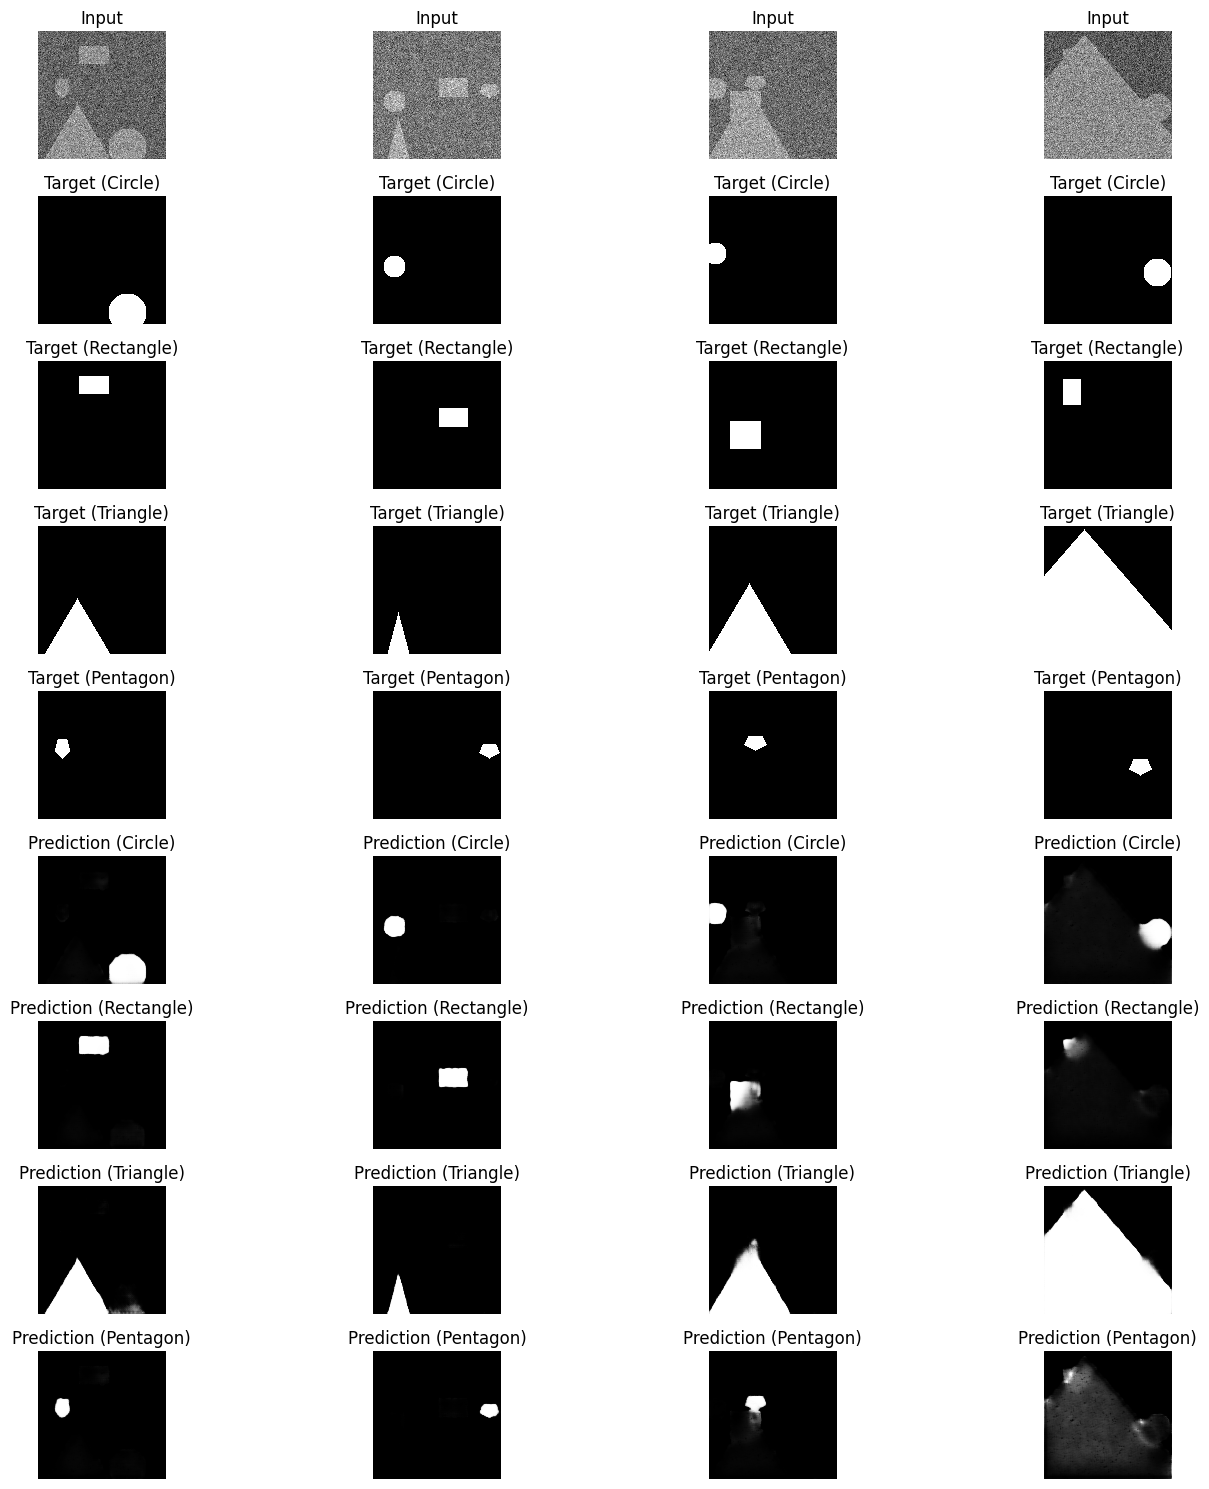

In [ ]:
# Visualize results, code here
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

model.eval()
with torch.no_grad():
    inputs, targets = next(iter(dataloader))
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)

    fig, axes = plt.subplots(9, 4, figsize=(15, 15))
    for i in range(4):
        axes[0, i].imshow(inputs[i, 0].cpu(), cmap='gray')
        axes[0, i].set_title('Input')
        axes[0, i].axis('off')

        axes[1, i].imshow(targets[i, 0].cpu(), cmap='gray')
        axes[1, i].set_title('Target (Circle)')
        axes[1, i].axis('off')

        axes[2, i].imshow(targets[i, 1].cpu(), cmap='gray')
        axes[2, i].set_title('Target (Rectangle)')
        axes[2, i].axis('off')

        axes[3, i].imshow(targets[i, 2].cpu(), cmap='gray')
        axes[3, i].set_title('Target (Triangle)')
        axes[3, i].axis('off')

        axes[4, i].imshow(targets[i, 3].cpu(), cmap='gray')
        axes[4, i].set_title('Target (Pentagon)')
        axes[4, i].axis('off')

        axes[5, i].imshow(outputs[i, 0].cpu(), cmap='gray')
        axes[5, i].set_title('Prediction (Circle)')
        axes[5, i].axis('off')

        axes[6, i].imshow(outputs[i, 1].cpu(), cmap='gray')
        axes[6, i].set_title('Prediction (Rectangle)')
        axes[6, i].axis('off')

        axes[7, i].imshow(outputs[i, 2].cpu(), cmap='gray')
        axes[7, i].set_title('Prediction (Triangle)')
        axes[7, i].axis('off')

        axes[8, i].imshow(outputs[i, 3].cpu(), cmap='gray')
        axes[8, i].set_title('Prediction (Pentagon)')
        axes[8, i].axis('off')

    plt.tight_layout()
    plt.show()

# High performance and well known model
https://pytorch.org/vision/stable/models.html

https://universe.roboflow.com/
